# Example: Modeling European Call or Put Contract Premiums
This example will familiarize students with computing the premium of European `call` and `put` contracts using a variety of approaches.

### Learning objectives
* __Objective 1__: compute the premium for European-style `call` contracts using both the [Monte Carlo simulation approach](https://en.wikipedia.org/wiki/Monte_Carlo_method) and the [Black-Scholes pricing formula](https://en.wikipedia.org/wiki/Black–Scholes_mode).
    * `Approach 1`: Monte Carlo estimate of European `call` contract price
    * `Approach 2`: Black–Scholes-Merton pricing formula for a European `call` contract
* __Objective 2__: compute the premium for European-style `put` contracts using both the [Monte Carlo simulation approach](https://en.wikipedia.org/wiki/Monte_Carlo_method) and the [Black-Scholes pricing formula](https://en.wikipedia.org/wiki/Black–Scholes_mode).
    * `Approach 1`: Monte Carlo estimate of European `put` contract price
    * `Approach 2`: Black–Scholes-Merton pricing formula for a European `put` contract
* __Objective 3__: compute how the premium of European `call` and `put` contracts changes as a function of the strike price `K,` all other parameters, e.g., time to expiration, held constant.

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* See the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl) for additional information on functions and types used in this material. 

In [14]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-133/module-1/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-133/module-1/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-133/module-1`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-133/module-1/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-133/module-1/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-133/module-1/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CH

## Objective 1: Compute the premium for European-style `call` contracts
We have a European `call` that expires in `T = 365` days with a strike price of `K = 60.0 USD`. The current share price is `S(0) = 60.0 USD`. Assume a risk-free rate of return of `5%` and an implied volatility of `10%`. The correct premium is $\mathcal{P}_{c}(K,S(0))$ = `4.08 USD/share`. Let's compute the European `call` premium using two approaches:
* Approach 1: Monte Carlo simulation of the share price by sampling the geometric Brownian motion model and then explicitly calculating the expectation in the pricing relationship
* Approach 2: Use the [Black–Scholes-Merton](https://en.wikipedia.org/wiki/Black–Scholes_model) pricing formula for a European `call` option contract

We start by defining the problem parameters that are shared between the approaches:

In [2]:
Δt = (1.0/365.0);
Sₒ = 60.0;
K = 60.0;
T = 365.0*Δt;
r̄ = 0.05;
σ̄ = 0.10;
𝒟(r,T) = exp(r*T);

### Approach 1: Monte Carlo estimate of European `call` contract price
Let's build an instance of the `MyGeometricBrownianMotionEquityModel` type, which holds the value for the price simulation using the `build(...)` method, and store this instance in the `model` variable:

In [3]:
model = build(MyGeometricBrownianMotionEquityModel, (
        μ = r̄, σ = σ̄));

Next, we build an instance of the `MyEuropeanCallContractModel` type, which holds the parameters for the `call` contract using the `build(...)` method. We store the contract model in the `call_contract_model` variable:

In [4]:
call_contract_model = build(MyEuropeanCallContractModel, (
        K = K, IV = σ̄, DTE = T, sense = 1, copy = 1));

Generate different numbers of sample paths and store these in the `number_of_samples` array.
We'll use these values to demonstrate the influence of sample size on the accuracy of the premium calculation:

In [5]:
number_of_samples = range(1.0,stop=5,step=1.0) |> collect |> (x-> exp10.(x)) |> (x-> 5*Int.(x));

Finally, we'll solve the geometric Brownian motion model for each number of sample paths using a `for` loop. For each pass of the loop: 
* First, we sample the geometric Brownian model instance using the `sample_endpoint(...)` function and compute the payoff at contract expiration using the `payoff(...)` function, 
* Next, we compute the discounted payoff array stored in the `P̄` array, then calculate the mean and standard error of the expected discounted future contract payoff. The mean value of the `P̄` array is the contract premium. 
* Finally, we populate a `DataFrame` instance that holds the data (number of paths, premium, the standard error `SE,` and the 95% CI) for each number of sample paths.

In [6]:
call_price_df = DataFrame();
for n ∈ number_of_samples
    S = sample_endpoint(model, (T = T, Sₒ = Sₒ), number_of_paths = n);
    P = payoff([call_contract_model], S);
    P̄ = (1/𝒟(r̄,T))*P[:,3];
    mean_value = mean(P̄);
    std_error_value = (1.0/sqrt(n))*std(P̄);
    CI95_value = 1.96*std_error_value;
    
    results_df = (
        
        n = n,
        mean_premium = mean_value,
        SE = std_error_value,
        CI95 = CI95_value
    );
    
    push!(call_price_df, results_df);
end
call_price_df

Row,n,mean_premium,SE,CI95
,Int64,Float64,Float64,Float64
1,50,3.62145,0.650417,1.27482
2,500,3.94727,0.203125,0.398125
3,5000,4.03137,0.065938,0.129238
4,50000,4.0936,0.0207254,0.0406217
5,500000,4.07912,0.00655886,0.0128554


### Approach 2: Black–Scholes-Merton pricing formula for a European `call` contract
We've implemented a `premium(...)` method that uses the Black–Scholes-Merton pricing formula to compute the premium of a European-style options contract. 
* First, create an instance of the `MyBlackScholesContractPricingModel` type, which holds the risk-free rate $\bar{r}$ and the initial share price $S_{\circ}$. We store this instance in the `bsm_model` variable:

In [7]:
bsm_model = build(MyBlackScholesContractPricingModel, (
        Sₒ = Sₒ, r = r̄
));

Then we pass this instance, a European `call` or `put` model, to the `premium(...)` function, which returns the premium value `𝒫`:

In [8]:
𝒫 = premium(call_contract_model, bsm_model)
println("The premium for the European call contract computed by Black-Scholes-Merton is: $(𝒫) USD/share")

The premium for the European call contract computed by Black-Scholes-Merton is: 4.083 USD/share


## Objective 2: Compute the premium for European-style `put` contracts
We have a European `put` that expires in `T = 365` days with a strike price `K = 60.0 USD`. The current share price is `S(0) = 60.0 USD`. Assume a risk-free rate of return of `5%` and an implied volatility of `10%`. The correct answer is $\mathcal{P}_{p}(K,S(0))\simeq$ `1.16 USD/share`. Let's compute the premium using two approaches:
* Approach 1: Monte Carlo simulation of the share price by sampling the geometric Brownian motion model and then explicitly calculating the expectation in the pricing relationship
* Approach 2: Use the [Black–Scholes](https://en.wikipedia.org/wiki/Black–Scholes_model) pricing formula for a European `put` option contract

#### Approach 1: Monte Carlo estimate of European `put` contract price
Let's build an instance of the `MyEuropeanPutContractModel` type, which holds the parameters for the `put` contract using the `build(...)` method. We store the contract model in the `put_contract_model` variable:

In [9]:
put_contract_model = build(MyEuropeanPutContractModel, (
        K = K, IV = σ̄, DTE = T, sense = 1, copy = 1));

Then repeat the simulation routine shown on the `call` contract case, but now we use the `put_contract_model` instance in place of the `call_contract_model` used previously:

In [10]:
put_price_df = DataFrame();
for n ∈ number_of_samples
    S = sample_endpoint(model, (T = T, Sₒ = Sₒ), number_of_paths = n);
    P = payoff([put_contract_model], S);
    P̄ = (1/𝒟(r̄,T))*P[:,3];
    mean_value = mean(P̄);
    std_error_value = (1.0/sqrt(n))*std(P̄);
    CI95_value = 1.96*std_error_value;
    
    results_df = (
        n = n,
        mean_premium = mean_value,
        SE = std_error_value,
        CI95 = CI95_value
    );
    
    push!(put_price_df, results_df);
end
put_price_df

Row,n,mean_premium,SE,CI95
,Int64,Float64,Float64,Float64
1,50,0.944135,0.242961,0.476203
2,500,1.13452,0.101661,0.199256
3,5000,1.1867,0.0320792,0.0628753
4,50000,1.15736,0.010241,0.0200725
5,500000,1.15232,0.0032117,0.00629494


### Approach 2:  Black–Scholes-Merton pricing formula for a European `put` contract
Like the `call` contract case, we'll use the `premium(...)` method, which uses the Black–Scholes-Merton pricing formula to compute the premium of a European-style options contract. 
* We pass the previous `MyBlackScholesContractPricingModel` instance and the new `put_contract_model` instance to the `premium(...)` function, which returns the premium value `𝒫` for the `put` contract:

In [11]:
𝒫 = premium(put_contract_model, bsm_model)
println("The premium for the European put contract computed by Black-Scholes is: $(𝒫) USD/share")

The premium for the European put contract computed by Black-Scholes is: 1.157 USD/share


## Objective 3: Premium versus the strike price for European `call` and `put` contracts
The premium paid for a European-style contract is a function of different factors, such as the distance between strike price `K` and the current value of the share price $S_{\circ}$. 

Let's compute this relationship for the `call` and `put` contracts we just considered. We calculate the premium for strike prices ranging from `K=20` to `K=100`, all other parameters held constant (`DTE = 365` days, `IV = 0.10`, $S_{\circ}$ = `60 USD/share`). We record the estimated premium for `call` and `put` contracts in the `df_BSM_simulation` variable (which is type `DataFrame` exported from the [DataFrames.jl package](https://dataframes.juliadata.org/stable/)). 

For each strike price in the `strikes` array:
* We first use the `build(…)` method to create an instance of the `MyEuropeanCallContractModel` and `MyEuropeanPutContractModel` types containing information about the contracts. This is stored in the `call_contract_model` (or `put_contract_model`) variables. 
* Next, we calculate the premium for each contract using the `premium(…)` function.
* Finally, we store the strike price `K` and the premium for the `call` and `put` contracts in the `df_BSM_simulation` variable.

In [12]:
start_strike = 20.0;
stop_strike = 100.0;
strikes = range(start_strike, stop = stop_strike, step=1) |> collect;
df_BSM_simulation = DataFrame()
for strike ∈ strikes
    
    call_contract_model = build(MyEuropeanCallContractModel, (
        K = strike, IV = σ̄, DTE = T, sense = 1));
    
    put_contract_model = build(MyEuropeanPutContractModel, (
        K = strike, IV = σ̄, DTE = T, sense = 1));
    
    P_call = premium(call_contract_model, bsm_model);
    P_put = premium(put_contract_model, bsm_model);
    
    results_tuple = (
        K = strike,
        premium_call = P_call, 
        premium_put = P_put
    );
    
    push!(df_BSM_simulation, results_tuple);
end

`Unhide` the code below to see how we plot the contract premium of each contract versus the strike price of the contract.

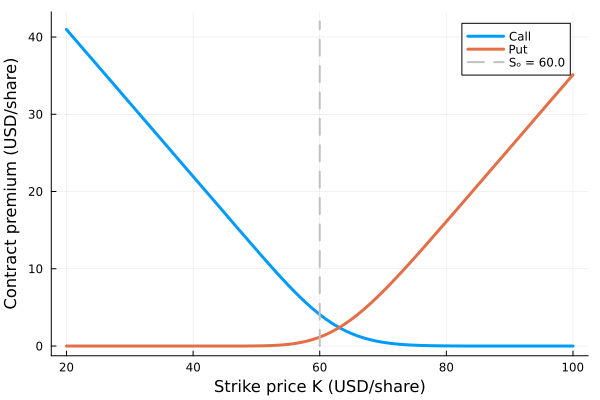

In [13]:
plot(df_BSM_simulation[:,1], df_BSM_simulation[:,2], label="Call", lw=3);
plot!(df_BSM_simulation[:,1], df_BSM_simulation[:,3], label="Put", lw=3)
vertical_line_y = range(0,step=0.1,stop=42) |> collect;
vertical_line_x = Sₒ*ones(length(vertical_line_y));
plot!(vertical_line_x,vertical_line_y, lw=2, c=:gray75, ls=:dash, label="Sₒ = 60.0")
xlabel!("Strike price K (USD/share)", fontsize=18)
ylabel!("Contract premium (USD/share)", fontsize=18)

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.